
#Alvin Luperon - Maestría de Ciencia de Datos y Inteligencia Artificial - UASD

#Proyecto Clasificación de Chest X-ray con Pneumonia usando PyTorch

#Comparativa de Entrenamiento: FAST vs OPTIMIZADO con CNN DenseNet121

In [1]:
import os
import torch
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'[INFO] Usando dispositivo: {device}')

# Importar módulos (Asegúrate que los archivos estén en la misma carpeta)
from data_loader import get_data_loaders
from model_builder import build_densenet121 # Solo importamos DenseNet121
from train import train_model
from evaluation import evaluate_model, plot_roc_curve
from utils import plot_training_curves
from eda import extended_eda
from pathlib import Path 


[INFO] Usando dispositivo: cuda


In [6]:
# Parámetros configurables
image_size = (224,224)
batch_size = 32
epochs_fast = 3             # Hiperparámetros Básicos
epochs_opt = 3             # Hiperparámetros Optimizados
learning_rate_fast = 0.001  # Tasa de aprendizaje alta
learning_rate_opt = 0.0001  # Tasa de aprendizaje baja para Fine-Tuning

In [9]:

base_path = Path.cwd() 
print(f"Ruta Base (Portable): {base_path}")

dataset_root = base_path / 'dataset' 
os.makedirs(dataset_root, exist_ok=True) # Aseguramos que la carpeta exista

train_dir = os.path.join(dataset_root, 'train')
val_dir = os.path.join(dataset_root, 'val')
test_dir = os.path.join(dataset_root, 'test')

# Rutas para guardar/cargar (Asegura consistencia con train.py)

# --- RUTAS INTERNAS PARA GUARDADO/CARGA (Usando Path / para consistencia) ---
# Creamos las carpetas de resultados si no existen
results_base_dir = base_path / "results"
os.makedirs(results_base_dir / "fast", exist_ok=True)
os.makedirs(results_base_dir / "optimized", exist_ok=True)
os.makedirs(results_base_dir / "metricascsv", exist_ok=True)

# Rutas para guardar/cargar (.pth)
MODEL_FAST_SAVE = results_base_dir / "fast" / "model.pth"
MODEL_OPT_SAVE = results_base_dir / "optimized" / "model.pth"

# Rutas para guardar/cargar (.csv)
METRICS_FAST_CSV = results_base_dir / "metricascsv" / "DenseNet121_fast_epoch.csv"
METRICS_OPT_CSV = results_base_dir / "metricascsv" / "DenseNet121_Optimizado_epoch.csv"


Ruta Base (Portable): c:\Users\alvin\OneDrive\Escritorio\Projecto Chest Xray\UASD - Chest Xray


## 1. Carga de Datos y EDA
### Carga de DataLoaders

In [10]:
# Cargar datos
#train_loader, val_loader, test_loader = get_data_loaders(train_dir, val_dir, test_dir, img_size=image_size, batch_size=batch_size)
train_loader, val_loader, test_loader, class_weights = get_data_loaders(train_dir, val_dir, test_dir, img_size=image_size, batch_size=batch_size)


[INFO] Configurando DataLoaders...
[INFO] Clases: ['NORMAL', 'PNEUMONIA']
[INFO] Conteos: [1341, 3875]
[INFO] Pesos (Normal, Pneumonia): [1.944817304611206, 0.673032283782959]
[INFO] Train samples: 5216, Val samples: 16, Test samples: 624


### EDA - Distribución de Clases
**Nota:** El dataset original de Chest X-Ray está muy desbalanceado, lo cual es visible aquí.

--- 🔬 Análisis Exploratorio de Datos (EDA) Extendido ---

[INFO] Dimensiones de la Imagen (C, H, W): torch.Size([3, 224, 224])
[INFO] Se esperan 3 canales (RGB) y tamaño 224x224.

[INFO] Distribución de Clases (Etiqueta 0: Normal, Etiqueta 1: Pneumonia):
  - Set de Entrenamiento: Counter({1: 3875, 0: 1341})
  - Set de Validación: Counter({0: 8, 1: 8})
  - Set de Prueba: Counter({1: 390, 0: 234})


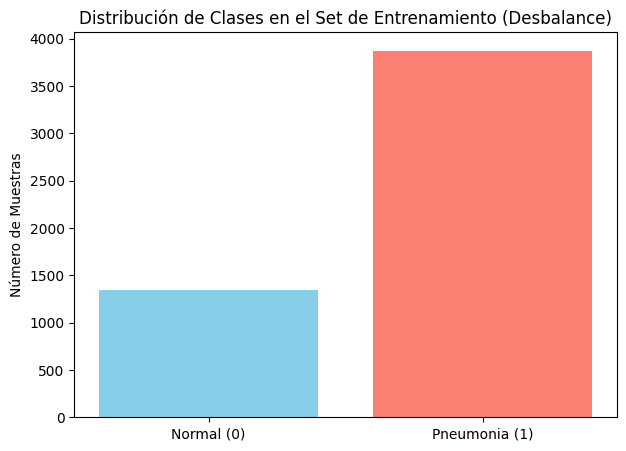


[INFO] Análisis de Intensidad de Píxeles por Clase (Indica Diferencias en Densidad/Opacidad):
Calculando histogramas de intensidad en 15 lotes...


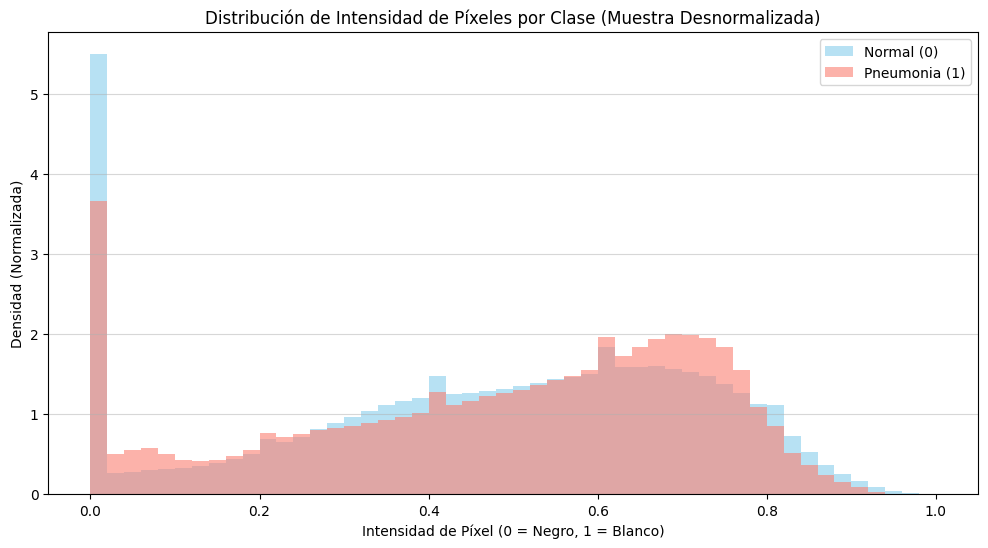


[INFO] Visualización de Muestras Aleatorias (Test Set - Calidad y Contraste):


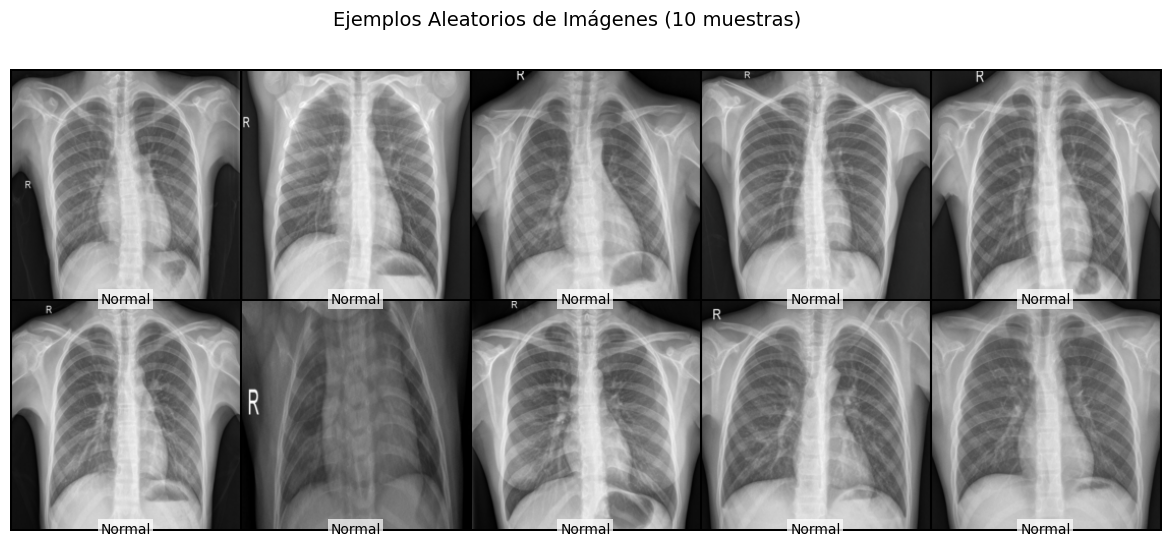


--- 🏁 EDA Completo ---


In [29]:
# Realizar EDA extendido
extended_eda(train_loader, val_loader, test_loader)

## 2. Entrenamiento / Carga de Modelos

In [9]:
choice = 'C' #input('¿Entrenar (E) o Cargar modelos (C)? ')

In [10]:
if choice.lower() == 'e':
    print("\n--- Escenario FAST MODE (DenseNet121 Congelado) ---")
    #FASTMODE: DenseNet121, layers Frozen (fast=True), pocos epochs, LR alto
    model_fast = build_densenet121(fast=True)
    history_fast = train_model(
        model_fast, train_loader, val_loader, device, 
        fast_mode=True, epochs=epochs_fast, lr=learning_rate_fast,
        save_path=base_path, model_name="DenseNet121_", save_batch_csv=False
    )
    
    print("\n--- Escenario OPTIMIZADO (DenseNet121 Fine-Tuning) ---")
    # OPTIMIZADO: DenseNet121, layers Fine-Tuning (fast=False), más epochs, LR bajo
    model_opt = build_densenet121(fast=False)
    history_opt = train_model(
        model_opt, train_loader, val_loader, device,
        fast_mode=False, epochs=epochs_opt, lr=learning_rate_opt,
        save_path=base_path, model_name="DenseNet121_", save_batch_csv=False, class_weights=class_weights
    )

elif choice.lower() == 'c':
    print("\n--- Cargando modelos pre-entrenados ---")
    # Cargar FAST MODE
    model_fast = build_densenet121(fast=True)
    model_fast.load_state_dict(torch.load(MODEL_FAST_SAVE, map_location=device))
    print(f"[INFO] Modelo FAST cargado desde: {MODEL_FAST_SAVE}")
    
    # Cargar OPTIMIZADO
    model_opt = build_densenet121(fast=False)
    model_opt.load_state_dict(torch.load(MODEL_OPT_SAVE, map_location=device))
    print(f"[INFO] Modelo OPTIMIZADO cargado desde: {MODEL_OPT_SAVE}")
    
else:
    print("Opción no válida. Ejecuta de nuevo la celda de elección.")


--- Cargando modelos pre-entrenados ---
[INFO] Descargando y construyendo modelo DenseNet121...


C:\Users\alvin\AppData\Local\Temp\ipykernel_29952\3092580907.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_fast.load_state_dict(torch.load(MODEL_FAST_SAVE, map_

[INFO] Modelo FAST cargado desde: C:\Users\alvin\OneDrive\Escritorio\Projecto Chest Xray\V3\results\fast\model.pth
[INFO] Descargando y construyendo modelo DenseNet121...


C:\Users\alvin\AppData\Local\Temp\ipykernel_29952\3092580907.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_opt.load_state_dict(torch.load(MODEL_OPT_SAVE, map_lo

[INFO] Modelo OPTIMIZADO cargado desde: C:\Users\alvin\OneDrive\Escritorio\Projecto Chest Xray\V3\results\optimized\model.pth


## 3. Evaluación en el Set de Prueba (Test Set)

[INFO] Evaluando DenseNet121 FAST...


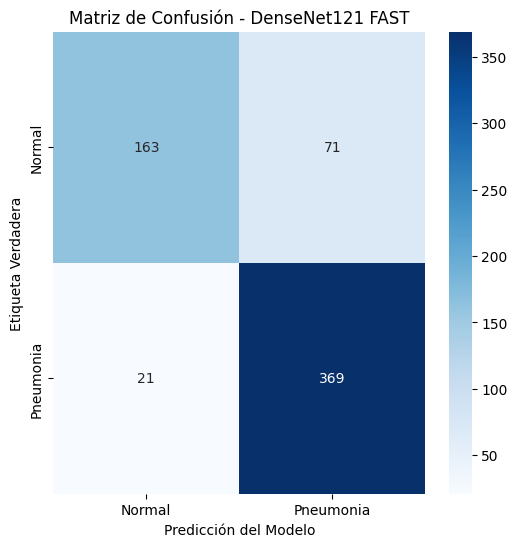

              precision    recall  f1-score   support

      Normal     0.8859    0.6966    0.7799       234
   Pneumonia     0.8386    0.9462    0.8892       390

    accuracy                         0.8526       624
   macro avg     0.8623    0.8214    0.8345       624
weighted avg     0.8563    0.8526    0.8482       624



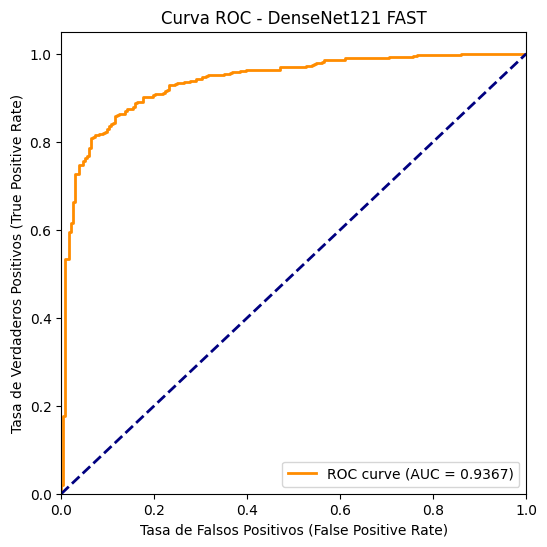

[INFO] Evaluando DenseNet121 OPTIMIZADO...


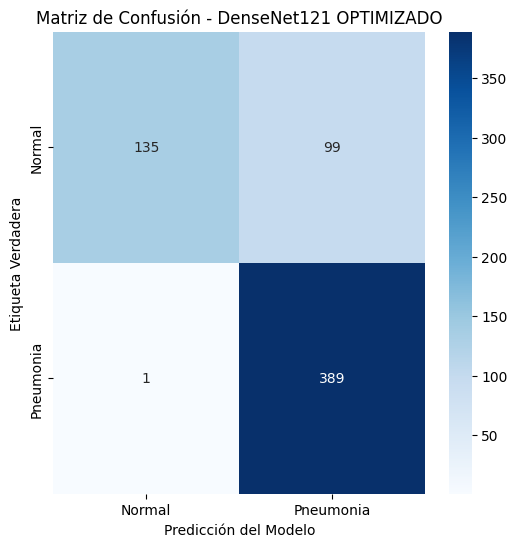

              precision    recall  f1-score   support

      Normal     0.9926    0.5769    0.7297       234
   Pneumonia     0.7971    0.9974    0.8861       390

    accuracy                         0.8397       624
   macro avg     0.8949    0.7872    0.8079       624
weighted avg     0.8704    0.8397    0.8275       624



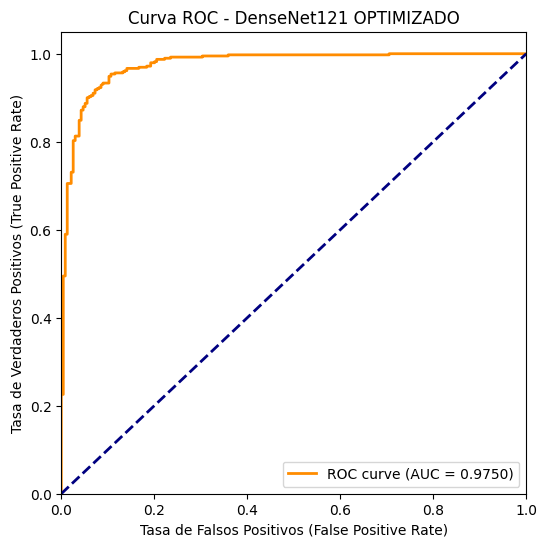

In [11]:
# Evaluación del Modelo FAST
cm_fast, report_fast = evaluate_model(model_fast, test_loader, device, model_tag="DenseNet121 FAST")

# Evaluación del Modelo OPTIMIZADO
cm_opt, report_opt = evaluate_model(model_opt, test_loader, device, model_tag="DenseNet121 OPTIMIZADO")

## 4. Visualizaciones y Comparativa de Resultados
### 4.1. Curvas de Entrenamiento (Loss y Accuracy por Epoch)

[INFO] Generando gráficas comparativas...


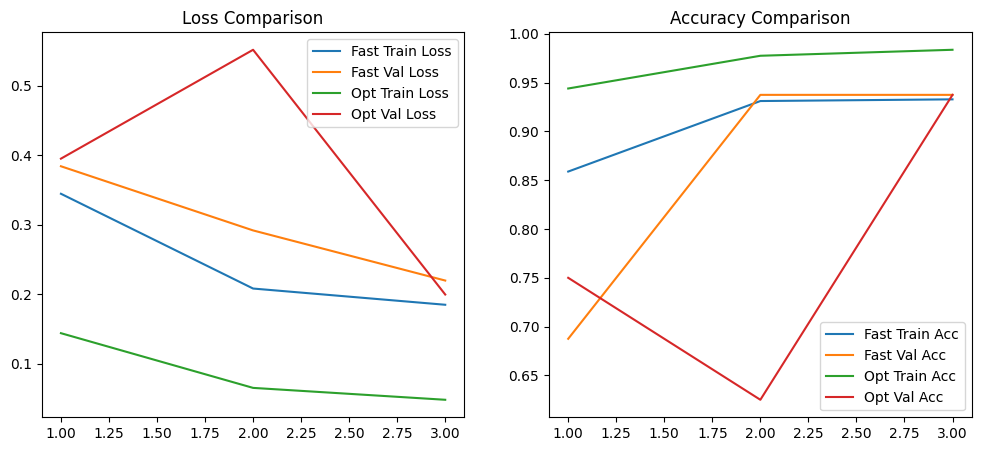

In [19]:
try:
    plot_training_curves(METRICS_FAST_CSV, METRICS_OPT_CSV)
except FileNotFoundError:
    print("No se encontraron los archivos CSV de métricas. Asegúrate de haber entrenado los modelos ('E').")

### 4.2. Tabla Comparativa de Métricas de Evaluación
Se comparan las métricas clave del **Classification Report** y el **AUC**.

In [20]:
metrics_data = {
    'Métrica': ['Accuracy (Test)', 'F1-Score (Normal)', 'F1-Score (Pneumonia)', 'AUC'],
    'FAST Mode': [
        report_fast['accuracy'], 
        report_fast['Normal']['f1-score'], 
        report_fast['Pneumonia']['f1-score'],
        report_fast['auc']
    ],
    'Optimized Mode': [
        report_opt['accuracy'], 
        report_opt['Normal']['f1-score'], 
        report_opt['Pneumonia']['f1-score'],
        report_opt['auc']
    ]
}

df_comparison = pd.DataFrame(metrics_data).set_index('Métrica')
df_comparison = df_comparison.style.format('{:.4f}')
print("\nTabla Comparativa de Rendimiento en el Test Set:")
display(df_comparison)


Tabla Comparativa de Rendimiento en el Test Set:


,FAST Mode,Optimized Mode
Métrica,,
Accuracy (Test),0.8526,0.8397
F1-Score (Normal),0.7799,0.7297
F1-Score (Pneumonia),0.8892,0.8861
AUC,0.9367,0.9750


### 4.3. Curva ROC Comparativa
**Nota:** Esta gráfica requiere recargar los modelos si se eligió 'C' para cargar.

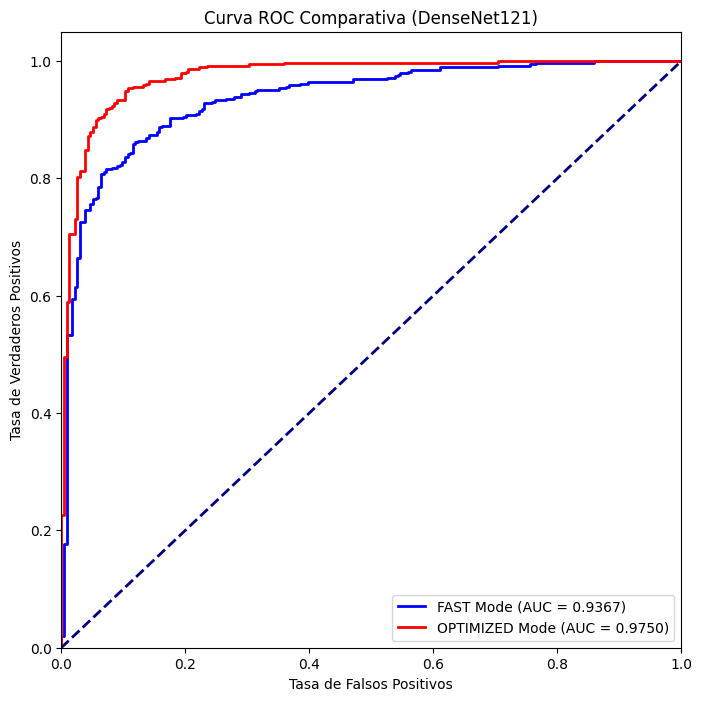

In [21]:
from sklearn.metrics import roc_curve, auc

def get_test_probs(model, test_loader, device):
    model.eval()
    model.to(device)
    y_true, y_probs = [], []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            outputs = model(inputs).cpu().numpy().flatten()
            y_probs.extend(outputs)
            y_true.extend(labels.cpu().numpy())
    return np.array(y_true), np.array(y_probs)

y_true_fast, y_probs_fast = get_test_probs(model_fast, test_loader, device)
y_true_opt, y_probs_opt = get_test_probs(model_opt, test_loader, device)

fpr_fast, tpr_fast, _ = roc_curve(y_true_fast, y_probs_fast)
roc_auc_fast = auc(fpr_fast, tpr_fast)

fpr_opt, tpr_opt, _ = roc_curve(y_true_opt, y_probs_opt)
roc_auc_opt = auc(fpr_opt, tpr_opt)

plt.figure(figsize=(8, 8))
plt.plot(fpr_fast, tpr_fast, color='blue', lw=2, label=f'FAST Mode (AUC = {roc_auc_fast:.4f})')
plt.plot(fpr_opt, tpr_opt, color='red', lw=2, label=f'OPTIMIZED Mode (AUC = {roc_auc_opt:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC Comparativa (DenseNet121)')
plt.legend(loc="lower right")
plt.show()